In [1]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [2]:
from google.colab import drive
drive._mount("/GD")

Mounted at /GD


In [3]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [1]:
pip install transformers

     |████████████████████████████████| 3.4 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 59.4 MB/s 
     |████████████████████████████████| 3.3 MB 27.9 MB/s 
     |████████████████████████████████| 895 kB 49.6 MB/s 
     |████████████████████████████████| 67 kB 7.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
df = pd.read_csv('data/title_conference.csv')

FileNotFoundError: ignored

In [ ]:
df.head()

AttributeError: ignored

In [4]:
import pandas as pd
df = pd.read_csv('df20.csv')
df.head()

,data,category
0,CURRICULUM VITAE\nShiv Ahluwalia\n(M) +9199111...,Education
1,E-mail: cashivahluwalia86@rediffmail.com\ncash...,Personal
2,OBJECTIVE\n,No_Label
3,"To learn, grow and make a career in the area o...",No_Label
4,CORE KNOWLEDGE & SKILL AREAS\n,No_Label


In [ ]:
#df['Conference'].value_counts()

In [5]:
df['category'].value_counts()

No_Label           13220
Work_Experience     2037
Education           1367
Personal            1213
Skills              1118
Name: category, dtype: int64

In [6]:
possible_labels = df.Conference.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

AttributeError: ignored

In [6]:
possible_labels = df.category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Education': 0,
 'No_Label': 2,
 'Personal': 1,
 'Skills': 3,
 'Work_Experience': 4}

In [7]:
df['label'] = df.category.replace(label_dict)

In [8]:
df.head()

,data,category,label
0,CURRICULUM VITAE\nShiv Ahluwalia\n(M) +9199111...,Education,0
1,E-mail: cashivahluwalia86@rediffmail.com\ncash...,Personal,1
2,OBJECTIVE\n,No_Label,2
3,"To learn, grow and make a career in the area o...",No_Label,2
4,CORE KNOWLEDGE & SKILL AREAS\n,No_Label,2


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [10]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [11]:
df.groupby(['category', 'label', 'data_type']).count()

data
category        label data_type       
Education       0     train       1162
                      val          205
No_Label        2     train      11237
                      val         1983
Personal        1     train       1031
                      val          182
Skills          3     train        950
                      val          168
Work_Experience 4     train       1731
                      val          306

In [12]:
import nltk
import seaborn as sns

In [13]:
categ = df['category']
categg = categ.unique()

In [14]:
 categg

array(['Education', 'Personal', 'No_Label', 'Skills', 'Work_Experience'],
      dtype=object)

In [ ]:
all_cat = sum(t, tt)
#len(set(t))

TypeError: ignored

In [15]:
categg = nltk.FreqDist(categ) 
categg

FreqDist({'Education': 1367,
          'No_Label': 13220,
          'Personal': 1213,
          'Skills': 1118,
          'Work_Experience': 2037})

In [16]:
#categg = nltk.FreqDist(categg)        
# create dataframe 
all_df = pd.DataFrame({'U_Category': list(categg.keys()),
                                'Count': list(categg.values())})

In [17]:
all_df

,U_Category,Count
0,Education,1367
1,Personal,1213
2,No_Label,13220
3,Skills,1118
4,Work_Experience,2037


In [19]:
g = all_df.nlargest(columns="Count", n = 50)  
plt.figure(figsize=(8,10))   
ax = sns.barplot(data=g, x= "Count", y = "U_Category")  
ax.set(ylabel = 'Count')  
plt.show()

NameError: ignored

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [19]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].data.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].data.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [20]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [21]:
len(dataset_train), len(dataset_val)

(16111, 2844)

In [22]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [23]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [24]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [25]:
epochs = 1

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [26]:
import random
import numpy as np

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [53]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}')
        t = len(y_preds[y_preds==label])/len(y_true)
        print(f'Accuracy_percent: {t}\n')
def plot(preds, labels):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  predicted = preds_flat
  y = labels_flat
  #plt.figure(figsize=(25,25))
  fig, ax = plt.subplots(figsize=(10,10))
  cm = confusion_matrix(predicted,y)
  cmd = ConfusionMatrixDisplay(cm,display_labels=['Education','Personal','No_Label','Skills','Work_Experience'])
  cmd.plot(ax=ax)
  cmd.ax_.set( title='C-Matrix', xlabel='Predicted', ylabel='Actual')
  plt.show()
  #fig, ax = plt.subplots(figsize=(10,10))
  #sns.heatmap(cm, annot=True,fmt='d')
  #sns.heatmap(cm, annot=True, fmt='d',
  #          xticklabels=df.category.values, yticklabels=df.category.values)
  #plt.ylabel('Actual')
  #plt.xlabel('Predicted')
  #plt.show()
  #print(cm)


In [29]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [30]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    #model.load_state_dict(torch.load('/content/drive/MyDrive/data_volume/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))    
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
    #torch.save(model.state_dict(), f'/content/drive/MyDrive/data_volume/finetuned_BERT_epoch_1.model')

        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/504 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.5584183994917169
Validation loss: 0.38603663829605234
F1 Score (Weighted): 0.8725356154814359


In [34]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [31]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [32]:
model.load_state_dict(torch.load('/content/drive/MyDrive/data_volume/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [33]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [34]:
accuracy_per_class(predictions, true_vals)

Class: Education
Accuracy: 189/205
Accuracy_percent: 0.9219512195121952

Class: Personal
Accuracy: 162/182
Accuracy_percent: 0.8901098901098901

Class: No_Label
Accuracy: 1773/1983
Accuracy_percent: 0.8940998487140696

Class: Skills
Accuracy: 112/168
Accuracy_percent: 0.6666666666666666

Class: Work_Experience
Accuracy: 250/306
Accuracy_percent: 0.8169934640522876



In [35]:
from sklearn import metrics
preds_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_vals.flatten()
predicted = preds_flat
y = labels_flat
print(metrics.classification_report(y, predicted, target_names=df['category'].unique()))

                 precision    recall  f1-score   support

      Education       0.74      0.92      0.82       205
       Personal       0.81      0.89      0.85       182
       No_Label       0.93      0.89      0.91      1983
         Skills       0.65      0.67      0.66       168
Work_Experience       0.79      0.82      0.80       306

       accuracy                           0.87      2844
      macro avg       0.78      0.84      0.81      2844
   weighted avg       0.88      0.87      0.88      2844



In [42]:
true_vals

array([3, 2, 0, ..., 3, 2, 2])

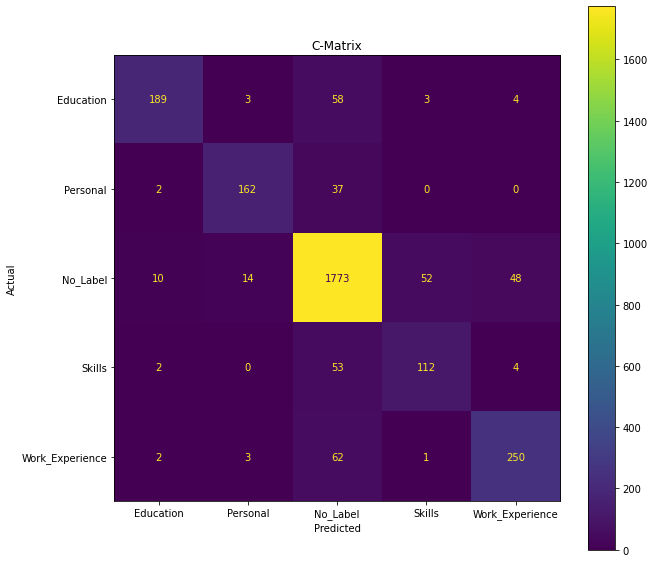

In [54]:
plot(predictions,true_vals)